In [1]:
!nvidia-smi

Mon Oct  9 20:20:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import the helper functions and import the other functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-09 20:20:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-09 20:20:25 (97.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
import tensorflow as tf

### Get the data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-10-09 20:20:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.202.207, 74.125.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2023-10-09 20:20:36 (143 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE=(224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode='categorical',
                                                                           batch_size=32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

### Steps for modelling experimentation
1. Experiment - Model 0
2. Data - random 10% of training data
3. Preprocessing : None
4. Model - feature extractor(EfficientNetB0)

## Model 0: Building a transfer learning model using a the keras functional API
### For feature engineering, we are changing the top layer
### The EfficientNetB0-7 -> means increasing complexities from 0 to 7
### Normalising is required when using Resnet50V2(efficientnet has rescaling features built in)



In [11]:
 #1.Create a base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#2. Freeze the base model(so the underlying pretrained models aren't updated )
base_model.trainable=False

#3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

#4. If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base model.
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after global average pooling 2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

#9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#10. Fit the model and save history
hostory_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data_10_percent,
                               validation_steps=int(0.25*len(test_data_10_percent)),
                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                      experiment_name='10_percent_feature_extraction')])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after global average pooling 2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231009-202208
Epoch 1/5
24/24 [==============================] - 24s 367ms/step - loss: 1.8556 - accuracy: 0.4307 - val_loss: 1.2596 - val_accuracy: 0.7270
Epoch 2/5
24/24 [==============================] - 5s 180ms/step - loss: 1.0904 - accuracy: 0.7720 - val_loss: 0.8516 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 5s 178ms/step - loss: 0.7807 - accuracy: 0.8453 - val_loss: 0.6953 - val_accuracy: 0.8339
Epoch 4/5
24/24 [==============================] - 4s 138ms/step - loss: 0.6305 - accuracy: 0.8680 - val_loss: 0.5965 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 5s 179ms/step - loss: 0.5399 - accuracy: 0.8867 - val_loss: 0.5327 - val_accuracy: 0.8750


In [13]:
# Evaluate on the full test data
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 7s 74ms/step - loss: 0.5580 - accuracy: 0.8616


[0.5580002665519714, 0.8615999817848206]

In [14]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

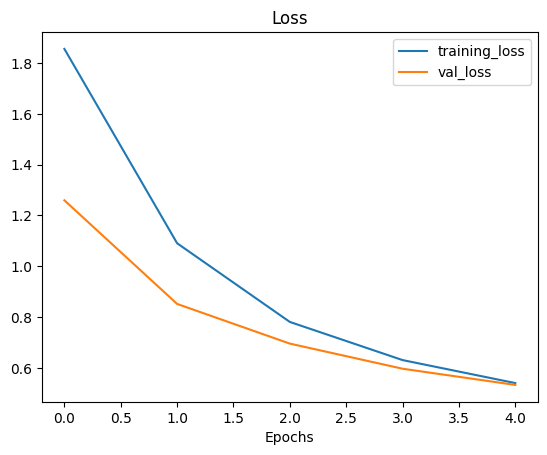

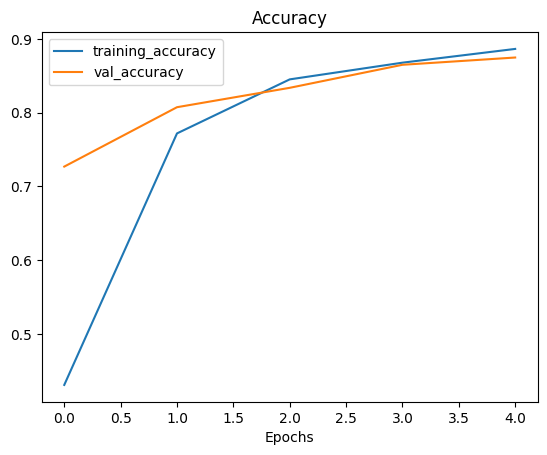

In [15]:
#Check out the model's training curves
plot_loss_curves(hostory_10_percent)